In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
from scipy import signal
from scipy.interpolate import LinearNDInterpolator
from typing import Union, List, Tuple, Dict
import os

from cell_inference.config import paths, params
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.transform.distribution_transformation import range2norm, range2logn
from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder


h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD, index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

### Set up configuration

Simulation configurations

In [2]:
loc_param_list = ['x','y','z','alpha','h','phi']
geo_param_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu','l_d']

loc_param_default = {'x': 0., 'y': 0., 'z': 50., 
                     'alpha': np.pi/4, 'h': 1., 'phi': 0.}
loc_param_default['d'], loc_param_default['theta'] = cart2pol(loc_param_default['x'], loc_param_default['z'])
geo_param_default = {'r_s': 8., 'l_t': 600., 'r_t': 1.25, 
                     'r_d': .28, 'r_tu': .28, 'l_d': 200.}

loc_param_range = {'x': (-50, 50), 'y': (-1400, 1400), 'z': (20., 200.), 
                   'alpha': (0, np.pi), 'h': (-1., 1.) ,'phi': (-np.pi, np.pi), 
                   'd': (20., 200.), 'theta': (-np.pi/3, np.pi/3)}
geo_param_range = {'r_s': (7., 12.), 'l_t': (20., 800.), 'r_t': (.6, 1.8), 
                   'r_d': (.1, .8), 'r_tu': (.1, .8), 'l_d': (100., 300.)}

loc_param_dist = {'x': 'unif', 'y': 'unif', 'z': 'unif', 
                     'alpha': 'unif', 'h': 'unif','phi': 'unif', 'd': 'unif', 'theta': 'norm'}
geo_param_dist = {'r_s': 'unif', 'l_t': 'unif', 'r_t': 'unif', 
                     'r_d': 'logn', 'r_tu': 'logn', 'l_d': 'unif'}

Trial configurations

In [3]:
number_samples = 1000
rand_seed = 12345

inference_list = ['h', 'phi', 'l_t']  # can use d, theta instead of x, z to represent location
randomized_list = ['alpha']  # randomized parameters not to inferred
randomized_list += inference_list
# parameters not in the two lists above are fixed at default.

Load gmax mapping file

In [4]:
gmax_mapping = h5py.File(paths.GMAX_MAPPING, 'r')

geo_list = [geo_param_list[idx] for idx in gmax_mapping['settings/geo_index']]
for i, key in enumerate(geo_list):
    geo_range = gmax_mapping['settings/geo_range'][i,:].copy()
    geo_range[0] = max(geo_param_range[key][0], geo_range[0])
    geo_range[1] = min(geo_param_range[key][1], geo_range[1])
    geo_param_range[key] = tuple(geo_range) 

squared_soma_radius = gmax_mapping['mapping'].attrs['squared_soma_radius']

# Use linear interpolation
gmax_interp = LinearNDInterpolator(gmax_mapping['mapping/geometry'][()], gmax_mapping['mapping/gmax'][()])

gmax_mapping.close()

# # Use linear regression
# clf = ClassifierBuilder()
# clf.load_clf(paths.RESOURCES_ROOT + "gmax_lin_reg_classifier.joblib")

def pred_gmax(geo_samples: Dict):
    geo = []
    for key in geo_list:
        if squared_soma_radius and key == 'r_s':
            geo.append(geo_samples[key]**2)
        else:
            geo.append(geo_samples[key])
    gmax = gmax_interp(np.column_stack(geo))
#     gmax = clf.predict(np.column_stack(geo))
    return gmax

Create configuration dictionary

In [5]:
config_dict = { 
    'Trial_Parameters': {'number_samples': number_samples, 'rand_seed': rand_seed, 
                         'inference_list': inference_list, 'randomized_list': randomized_list}, 
    'Simulation_Parameters': {'loc_param_list': loc_param_list, 'geo_param_list': geo_param_list, 
                              'loc_param_default': loc_param_default, 'geo_param_default': geo_param_default, 
                              'loc_param_range': loc_param_range, 'geo_param_range': geo_param_range, 
                              'loc_param_dist': loc_param_dist, 'geo_param_dist': geo_param_dist}
}

### Generate random samples

In [6]:
rng = np.random.default_rng(rand_seed)

def generator_dist(p_range: Union[List[float],Tuple[float],np.ndarray], dist_type: str, rng: np.random.Generator):
    if dist_type == 'unif':
        def generator(size=None):
            return rng.uniform(low=p_range[0], high=p_range[1], size=size)
    if dist_type == 'norm':
        mu, sigma = range2norm(p_range[0], p_range[1], n_sigma=3)
        def generator(size=None):
            return rng.normal(loc=mu, scale=sigma, size=size)
    if dist_type == 'logn':
        mu, sigma = range2logn(p_range[0], p_range[1], n_sigma=3)
        def generator(size=None):
            return rng.lognormal(mean=mu, sigma=sigma, size=size)
    return generator

def generate_parameters(num: int, param_keys: List[str], param_default: List[float], 
                        param_range: List[Union[List[float],Tuple[float],np.ndarray]], param_dist: List[str]):
    array_size = num
    param_array = {}
    for key in param_keys:
        if key in randomized_list:
            generator = generator_dist(param_range[key], param_dist[key], rng)
            param_array[key] = generator(size=array_size)
        else:
            param_array[key] = np.full(array_size, param_default[key])
    return param_array

Location parameters

In [7]:
loc_param_gen = loc_param_list.copy()
if 'd' in randomized_list and 'theta' in randomized_list:
    loc_param_gen[loc_param_gen.index('x')] = 'd'
    loc_param_gen[loc_param_gen.index('z')] = 'theta'

loc_param_samples = generate_parameters(number_samples, loc_param_gen, loc_param_default, loc_param_range, loc_param_dist)

if 'd' in randomized_list and 'theta' in randomized_list:
    loc_param_samples['x'], loc_param_samples['z'] = pol2cart(loc_param_samples['d'],loc_param_samples['theta'])

loc_param = np.column_stack([loc_param_samples[key] for key in loc_param_list])

Geometery parameters

In [8]:
geo_param_samples = generate_parameters(number_samples, geo_param_list, geo_param_default, geo_param_range, geo_param_dist)

geo_param = np.column_stack([geo_param_samples[key] for key in geo_param_list])

gmax = pred_gmax(geo_param_samples)

Get parameters to be inferred as labels

In [9]:
samples = {**geo_param_samples, **loc_param_samples}
labels = np.column_stack([ samples[key] for key in inference_list ])
rand_param = np.column_stack([ samples[key] for key in randomized_list[:-len(inference_list)] ])

np.set_printoptions(suppress=True)
print(loc_param.shape)
print(geo_param.shape)
print(labels.shape)

(1000, 6)
(1000, 6)
(1000, 3)


### Create simulation and run

In [10]:
sim = Simulation(geometry = geo_standard, 
                 electrodes = params.ELECTRODE_POSITION, 
                 cell_type = CellTypes.ACTIVE, 
                 loc_param = loc_param, 
                 geo_param = geo_param,
                 spike_threshold = -30, 
                 gmax = gmax, 
                 scale = 1., 
                 ncell = number_samples)

sim.run_neuron_sim()

Check invalid spiking cases

In [11]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes

%matplotlib inline

def plot_v(sim: Simulation, cell_idx: np.ndarray = None,
           figsize: Union[List[float],Tuple[float]] = (6,2)) -> Tuple[Figure, Axes]:
    if cell_idx is None:
        cell_idx = np.arange(sim.ncell)
    elif cell_idx.size == 0:
        return
    t = sim.t()
    fig, axs = plt.subplots(nrows=cell_idx.size, ncols=1)
    fig.set_size_inches(figsize[0],figsize[1]*cell_idx.size)
    axs = np.asarray(axs).ravel()
    for i, ax in enumerate(axs):
        ax.plot(t, sim.v(cell_idx[i]), label="cell %d" % (cell_idx[i]))
        ax.set_ylabel('Vm (mV)')
        ax.legend(loc=1)
    axs[0].set_title('Membrane Voltage vs Time')
    axs[-1].set_xlabel('Time (ms)')
    plt.show()
    return fig, axs

def invalid_index(sim):
    # index of valid spiking cells
    nspk, tspk = sim.get_spike_number('all')
    invalid = np.nonzero(nspk != 1)[0]
    return invalid, tspk

In [12]:
invalid_idx, tspk = invalid_index(sim)
print("Number of invalid samples: %d out of %d" % (invalid_idx.size, number_samples))

_ = plot_v(sim, cell_idx=invalid_idx)

mem_volt = sim.v('all')

Number of invalid samples: 0 out of 1000


### Get LFPs

Reshape LFP array. Filter each channel. Get window of spike for each sample.

In [13]:
lfp = sim.get_lfp('all').transpose((0,2,1))  # (cells x channels x time) -> (cells x time x channels)

filt_b, filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                              params.FILTER_CRITICAL_FREQUENCY,
                              params.BANDFILTER_TYPE,
                              fs=params.FILTER_SAMPLING_RATE)

filtered_lfp = signal.lfilter(filt_b,filt_a,lfp,axis=1)  # filter along time axis

pk_tr_idx_in_window = 16  # 16*0.025=0.4 ms
lfp_list = []
for i in range(number_samples):
#     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    fst_idx = first_pk_tr(filtered_lfp[i])
    start, end = get_spike_window(filtered_lfp[i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    lfp_list.append(filtered_lfp[i,start:end,:])

t = sim.t()[:params.WINDOW_SIZE]
windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)

### Save configurations and simulation data

In [14]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Ori2_Geo1_params')

TRIAL_CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp')  # LFP and labels
MEM_VOLT_PATH = os.path.join(TRIAL_PATH, 'mem_volt')  # membrane voltage and spike times

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    print("The new data directory is created!")

if not os.path.exists(TRIAL_PATH):
    os.makedirs(TRIAL_PATH)
    print("The new trial directory is created!")

The new trial directory is created!


In [15]:
np.savez(LFP_PATH, t=t, x=windowed_lfp, y=labels, rand_param=rand_param, gmax=gmax)
np.savez(MEM_VOLT_PATH, v=mem_volt, spk=tspk)
with open(TRIAL_CONFIG_PATH, 'w') as fout:
    json.dump(config_dict, fout, indent=2)

### Verify LFPs

We hand compare the LFP plots generated by our data

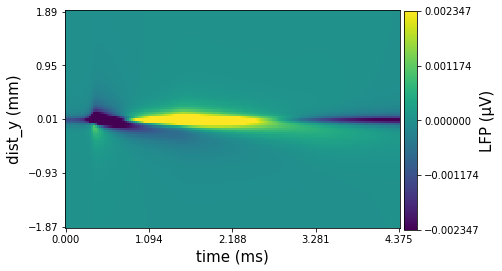

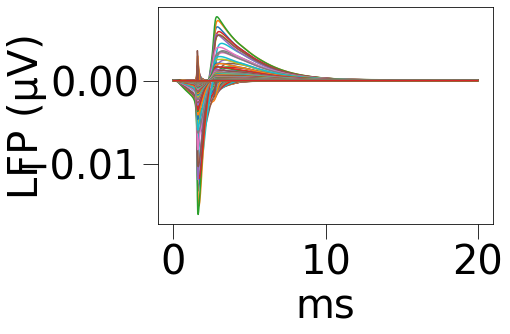

In [16]:
%matplotlib inline

cell_idx = 0

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(params.ELECTRODE_POSITION[:,0])
e_idx = ((params.ELECTRODE_POSITION[:,0]==x_dist[ix]) & 
         (params.ELECTRODE_POSITION[:,1]>=ylim[0]) & 
         (params.ELECTRODE_POSITION[:,1]<=ylim[1]))

_ = plot_lfp_heatmap(t,params.ELECTRODE_POSITION[e_idx, 1],
                              windowed_lfp[cell_idx][:,e_idx], vlim='auto',
                              fontsize=15,labelpad=0,ticksize=10,nbins=5)

_ = plot_lfp_traces(sim.t(), lfp[cell_idx])